In [30]:
from typing import List, NamedTuple, Dict, Tuple
from collections import Counter, defaultdict
from scratch.linear_algebra import Vector, distance
import requests 
import csv
import matplotlib.pyplot as plt
import random
from scratch.machine_learning import split_data
import tqdm
from scratch.statistics import mean

In [2]:
def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner


print(raw_majority_vote(["a", "b", "c", "b"]))

b


In [6]:
def majority_vote(labels: List[str]) -> str:
    vote_counts = Counter(labels)
    winner, winner_counts = vote_counts.most_common(1)[0]
    num_winners = len(
        [count for count in vote_counts.values() if count == winner_counts]
    )

    if num_winners == 1:
        return winner
    else:
        return majority_vote(labels[:-1])


print(majority_vote(["a", "b", "c", "b", "a"]))

b


In [8]:
class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def knn_classify(k: int, labaled_points: List[LabeledPoint], new_point: Vector) -> str:
    by_distance = sorted(labaled_points, key=lambda lp: distance(lp.point, new_point))

    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    return majority_vote(k_nearest_labels)

In [10]:
data = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

with open("data/iris.data", 'w') as f:
    f.write(data.text)

In [17]:
def parse_iris_row(row: List[str]) -> LabeledPoint:
    measurements = [float(value) for value in row[:-1]]

    label = row[-1].split("-")[-1]

    return LabeledPoint(measurements, label)

with open('data/iris.data', 'r') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader if len(row) > 0]

points_by_species: Dict[str, List[Vector]] = defaultdict(list)

for iris in iris_data:
    points_by_species[iris.label].append(iris.point)


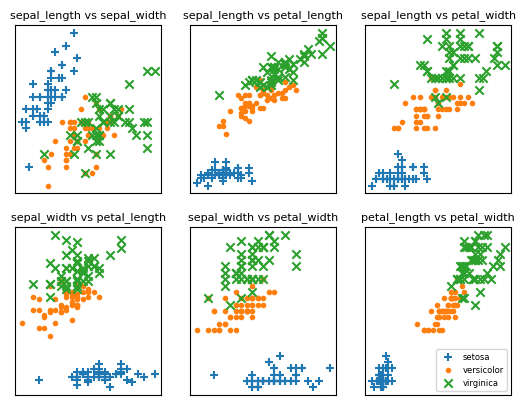

In [20]:
metrics = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

pairs = [(i, j) for i in range(4) for j in range(4) if i < j]

marks = ['+', '.', 'x']

fig, ax = plt.subplots(2, 3)

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row, col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])

        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc="lower right", prop={'size': 6})
plt.show()

In [24]:
random.seed(42)

iris_train, iris_test = split_data(iris_data, 0.70)
print(len(iris_train), len(iris_test))

105 45


In [26]:
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label

    if predicted == actual:
        num_correct += 1

    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 21, ('virginica', 'virginica'): 12, ('versicolor', 'versicolor'): 11, ('virginica', 'versicolor'): 1})


In [28]:
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distance(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim)) for _ in range(num_pairs)]

In [31]:
dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(42)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distance(dim, 10000)
    avg_distances.append(mean(distances))
    min_distances.append(min(distances))

Curse of Dimensionality: 100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


In [33]:
min_avg_ratio = [min_dist / avg_dist for min_dist, avg_dist in zip(min_distances, avg_distances)] 